# Rodando com os dados sintéticos + ground truth
Hyperparameters calibrated

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from IPython.display import Image, display
import base64
warnings.filterwarnings('ignore')

import plotly.io as pio
pio.renderers.default = "iframe"

In [2]:
from robyn.data.entities.mmmdata import MMMData
from robyn.data.entities.holidays_data import HolidaysData
from robyn.data.entities.hyperparameters import Hyperparameters, ChannelHyperparameters
from robyn.modeling.entities.modelrun_trials_config import TrialsConfig
from robyn.modeling.clustering.clustering_config import ClusteringConfig
from robyn.allocator.entities.allocation_params import AllocatorParams

from robyn.modeling.feature_engineering import FeatureEngineering

from robyn.visualization.feature_visualization import FeaturePlotter
from robyn.modeling.model_executor import ModelExecutor
from robyn.modeling.entities.enums import NevergradAlgorithm, Models

from robyn.modeling.pareto.pareto_optimizer import ParetoOptimizer

from robyn.allocator.entities.allocation_params import AllocatorParams
from robyn.allocator.allocator import BudgetAllocator
from robyn.allocator.constants import (
    SCENARIO_MAX_RESPONSE,
    CONSTRAINT_MODE_EQ,
    DATE_RANGE_ALL,
    DEFAULT_CONSTRAINT_MULTIPLIER,
    ALGO_SLSQP_AUGLAG,
)

from robyn.modeling.clustering.clustering_config import ClusteringConfig, ClusterBy
from robyn.modeling.clustering.cluster_builder import ClusterBuilder
from robyn.data.entities.enums import DependentVarType

from robyn.visualization.allocator_visualizer import AllocatorVisualizer


2025-12-16 20:38:26,698 - robyn - INFO - Logging is set up to console only.


### Load and prepare data

In [3]:
path = '/home/cairo/mba/tcc-dsa-mcc/data/'

df_media = pd.read_csv(path + 'mmm_data_synth.csv')

### Robyn

In [4]:
# Rename columns to match Robyn conventions
robyn_data = df_media.rename(columns={
    'date': 'ds',
    'sales_revenue': 'revenue'
}).copy()

media_spend = ['google_spend', 'meta_spend', 'tv_spend']

print("✅ Data preparation complete")
print(f"Final dataset shape: {robyn_data.shape}")


✅ Data preparation complete
Final dataset shape: (156, 23)


In [5]:
def setup_mmm_data(robyn_data) -> MMMData:

    mmm_data_spec = MMMData.MMMDataSpec(
        dep_var="revenue",
        dep_var_type="revenue",
        date_var="ds",
        context_vars=['selic_rate', 'incc_index'],
        factor_vars=[],
        paid_media_spends=["google_spend", "meta_spend", "tv_spend"],
        paid_media_vars=["google_clicks", "meta_impressions", "tv_spend"],
        organic_vars=["ga_engaged_sessions", "ga_page_views", "meta_reach"],
        window_start="2021-01-01",
        window_end="2023-12-31", # vamos manter os 3 anos
    )

    return MMMData(data=robyn_data, mmmdata_spec=mmm_data_spec)


mmm_data = setup_mmm_data(robyn_data)

In [6]:
# Adequação para o Robyn com N=150
hyperparameters = Hyperparameters(
    {
        "google_spend": ChannelHyperparameters(
            alphas=[0.5, 1.5],      # Range moderado - dados bem comportados
            gammas=[0.2, 0.5],      # Efeitos de curto prazo bem identificáveis
            thetas=[0.1, 0.6],      # Saturação identificável com N=150
        ),
        "meta_spend": ChannelHyperparameters(
            alphas=[0.5, 1.5],
            gammas=[0.2, 0.5],
            thetas=[0.1, 0.6],
        ),
        "tv_spend": ChannelHyperparameters(
            alphas=[0.8, 2.0],      
            gammas=[0.3, 0.7],      # TV permite gamma maior
            thetas=[0.2, 0.7],
        ),
        "ga_engaged_sessions": ChannelHyperparameters(
            alphas=[0.5, 1.5],
            gammas=[0.3, 0.8],
            thetas=[0, 0.3],
        ),
        "ga_page_views": ChannelHyperparameters(
            alphas=[0.5, 1.5],
            gammas=[0.3, 0.7],
            thetas=[0, 0.3],
        ),
        "meta_reach": ChannelHyperparameters(
            alphas=[0.5, 1.5],
            gammas=[0.3, 0.7],
            thetas=[0, 0.2],
        ),
        
    },
    adstock="geometric",
    lambda_=[0.1, 2.0],     # Range moderado - regularização balanceada
    train_size=[0.7, 0.8], # Validação robusta possível com N=150
)

print("Hyperparameters setup complete.")

Hyperparameters setup complete.


In [7]:
# Create HolidaysData object
df_holidays = pd.read_csv(path + 'br_holidays.csv')
df_holidays['ds'] = pd.to_datetime(df_holidays['ds'])

holidays_data = HolidaysData(
    dt_holidays=df_holidays,
    prophet_vars=["trend", "season", "holiday"],
    prophet_country="BR",
    prophet_signs=["default", "default", "default"]
)

In [8]:
# Setup FeaturizedMMMData
feature_engineering = FeatureEngineering(mmm_data, hyperparameters, holidays_data)
featurized_mmm_data = feature_engineering.perform_feature_engineering()

2025-12-16 20:38:26,950 - robyn.modeling.feature_engineering - INFO - Starting feature engineering process
2025-12-16 20:38:26,951 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2025-12-16 20:38:26,952 - robyn.modeling.feature_engineering - INFO - Starting Prophet decomposition
2025-12-16 20:38:26,981 - cmdstanpy - DEBUG - input tempfile: /tmp/tmprdeg1xgr/h0l63hbh.json
2025-12-16 20:38:26,985 - cmdstanpy - DEBUG - input tempfile: /tmp/tmprdeg1xgr/raaar4gr.json
2025-12-16 20:38:26,986 - cmdstanpy - DEBUG - idx 0
2025-12-16 20:38:26,986 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-12-16 20:38:26,987 - cmdstanpy - DEBUG - CmdStan args: ['/home/cairo/mba/tcc-dsa-mcc/tcc-mmm/.venv/lib/python3.11/site-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=5248', 'data', 'file=/tmp/tmprdeg1xgr/h0l63hbh.json', 'init=/tmp/tmprdeg1xgr/raaar4gr.json', 'output', 'file=/tmp/tmprdeg1xgr/prophet_model_91wpetr/prophet_model-20251216203826.csv', '

2025-12-16 20:38:27,056 - robyn.visualization.feature_visualization - INFO - Initializing FeaturePlotter
2025-12-16 20:38:27,056 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: google_clicks
2025-12-16 20:38:27,056 - robyn.visualization.feature_visualization - INFO - Found result for channel google_clicks
2025-12-16 20:38:27,123 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel google_clicks


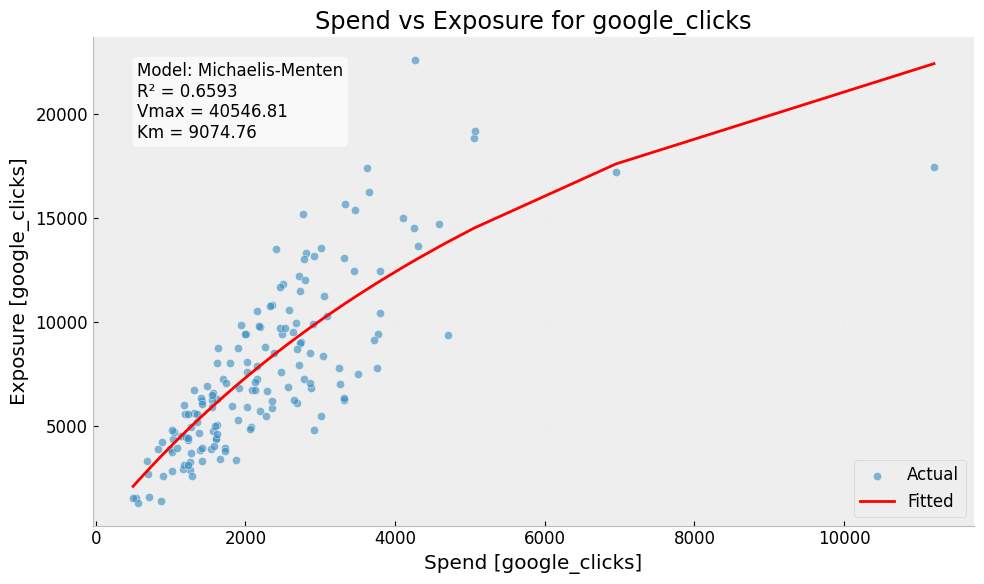

2025-12-16 20:38:27,185 - robyn.visualization.feature_visualization - INFO - Generating spend-exposure plot for channel: meta_impressions
2025-12-16 20:38:27,186 - robyn.visualization.feature_visualization - INFO - Found result for channel meta_impressions
2025-12-16 20:38:27,234 - robyn.visualization.feature_visualization - INFO - Successfully generated spend-exposure plot for channel meta_impressions


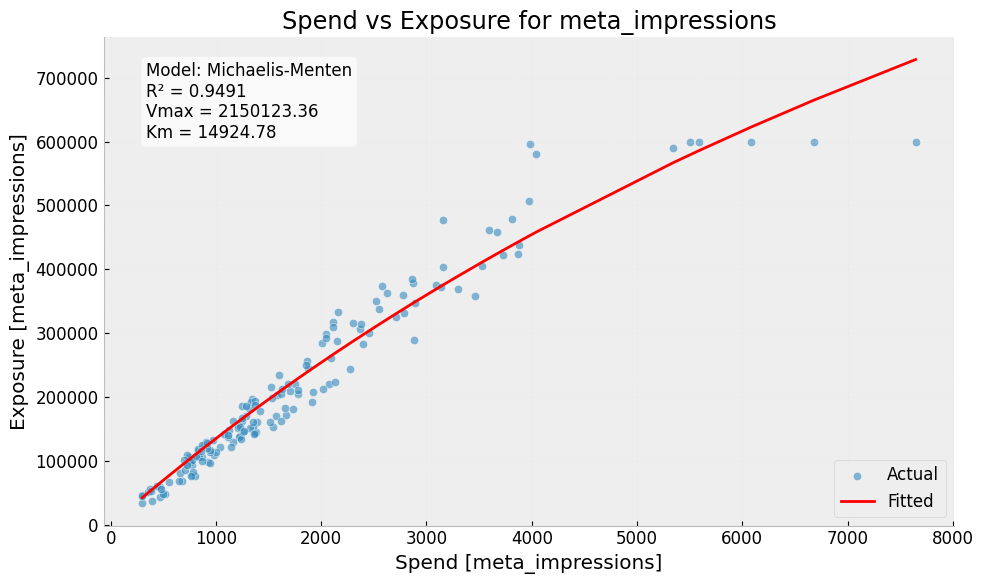

In [9]:
%matplotlib inline

# Create plotter instance
feature_plotter = FeaturePlotter(mmm_data, hyperparameters, featurized_mmm_data)
results_list = featurized_mmm_data.modNLS["results"]

# Plot each channel
for result in results_list:
    channel = result["channel"]
    try:
        # Get the figure dictionary
        fig_dict = feature_plotter.plot_spend_exposure(channel)
        
        if "spend-exposure" in fig_dict:
            fig = fig_dict["spend-exposure"]
            # Need to get the axis from the figure
            ax = fig.get_axes()[0]
            # Draw the figure to make sure it's rendered
            fig.canvas.draw()
            # Display using display instead of show
            from IPython.display import display
            display(fig)
            
    except ValueError as e:
        print(f"Skipping {channel}: {str(e)}")
    except Exception as e:
        print(f"Error plotting {channel}: {str(e)}")

In [10]:
plt.ioff()
model_executor = ModelExecutor(
    mmmdata=mmm_data,
    holidays_data=holidays_data,
    hyperparameters=hyperparameters,
    calibration_input=None,
    featurized_mmm_data=featurized_mmm_data,
)

trials_config = TrialsConfig(iterations=2000, trials=8)

output_models = model_executor.model_run(
    trials_config=trials_config,
    ts_validation=True,
    # Vou testar se o True funciona com dados sintéticos
    add_penalty_factor=None, # Penalize unstable models - não funcionou com True
    rssd_zero_penalty=True,  # Penalize if DECOMP.RSSD > threshold
    cores=20,
    nevergrad_algo=NevergradAlgorithm.TWO_POINTS_DE,
    intercept=True,
    intercept_sign="non_negative",
    model_name=Models.RIDGE,
)
plt.close()

2025-12-16 20:38:27,309 - robyn.modeling.base_model_executor - INFO - Initializing BaseModelExecutor
2025-12-16 20:38:27,310 - robyn.modeling.model_executor - INFO - Starting model execution with model_name=Models.RIDGE
2025-12-16 20:38:27,310 - robyn.modeling.base_model_executor - INFO - Input validation successful
2025-12-16 20:38:27,311 - robyn.modeling.base_model_executor - INFO - Preparing hyperparameters
2025-12-16 20:38:27,311 - robyn.modeling.base_model_executor - INFO - Completed hyperparameter preparation with 20 parameters to optimize
2025-12-16 20:38:27,311 - robyn.modeling.model_executor - INFO - Initializing Ridge model builder
2025-12-16 20:38:27,315 - robyn.modeling.model_executor - INFO - Building models with configured parameters
2025-12-16 20:38:27,315 - robyn.modeling.ridge.ridge_data_builder - INFO - Collecting hyperparameters for optimization...
Running trial 1 of 8:   0%|          | 0/2000 [00:00<?, ?it/s]2025-12-16 20:38:27,324 - rpy2.situation - INFO - cffi mod

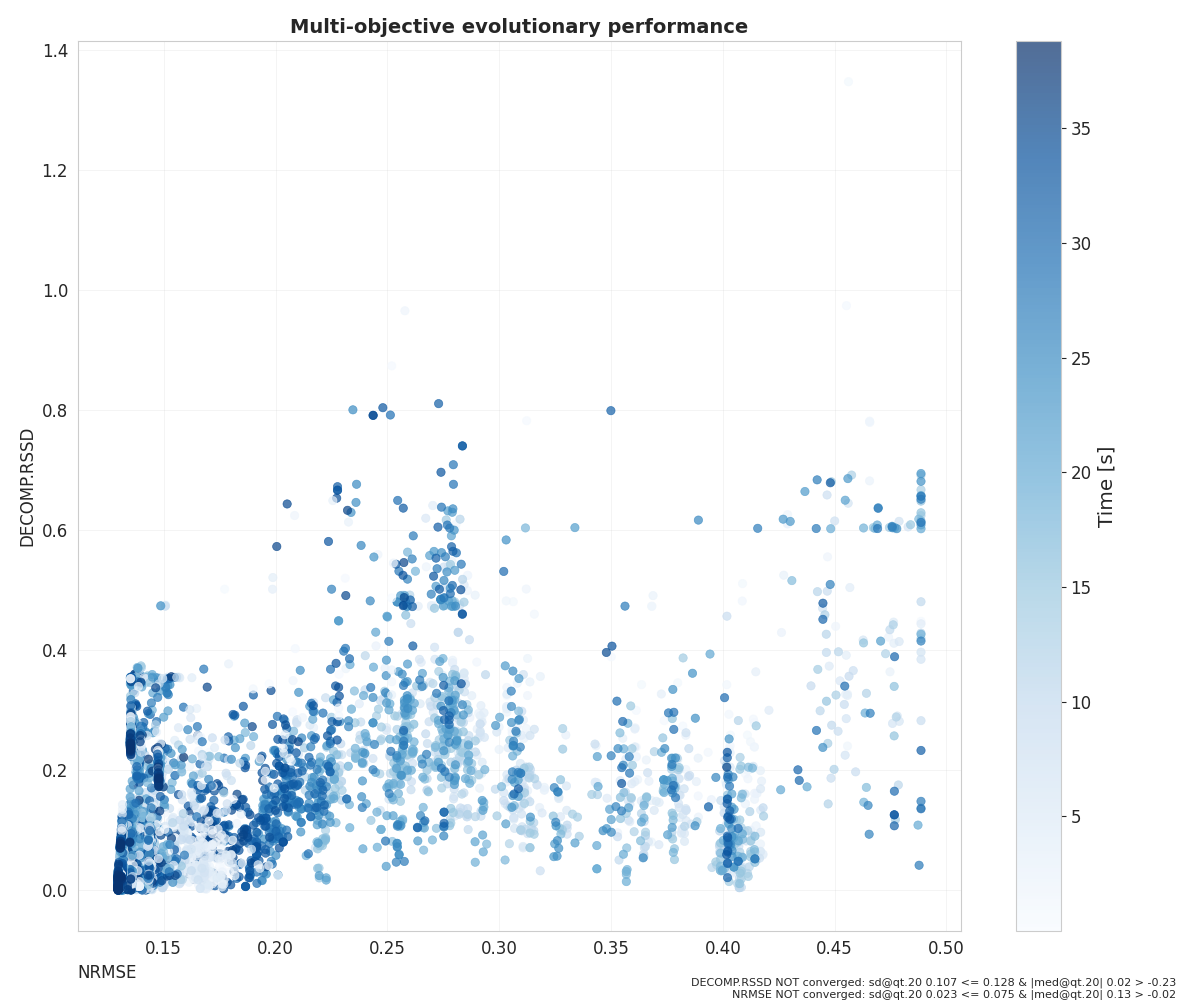

In [11]:
# Display the MOO Cloud Plot
if "moo_cloud_plot" in output_models.convergence:
    moo_cloud_plot = output_models.convergence["moo_cloud_plot"]
    display(Image(data=base64.b64decode(moo_cloud_plot)))


MOO Distribution Plot

This plot shows the distribution of objective values across all trials:

- Shows the spread of NRMSE and decomposition errors
- Helps identify if optimization has converged to stable solutions
- Wide distributions may indicate need for more iterations
- Narrow distributions suggest consistent model performance


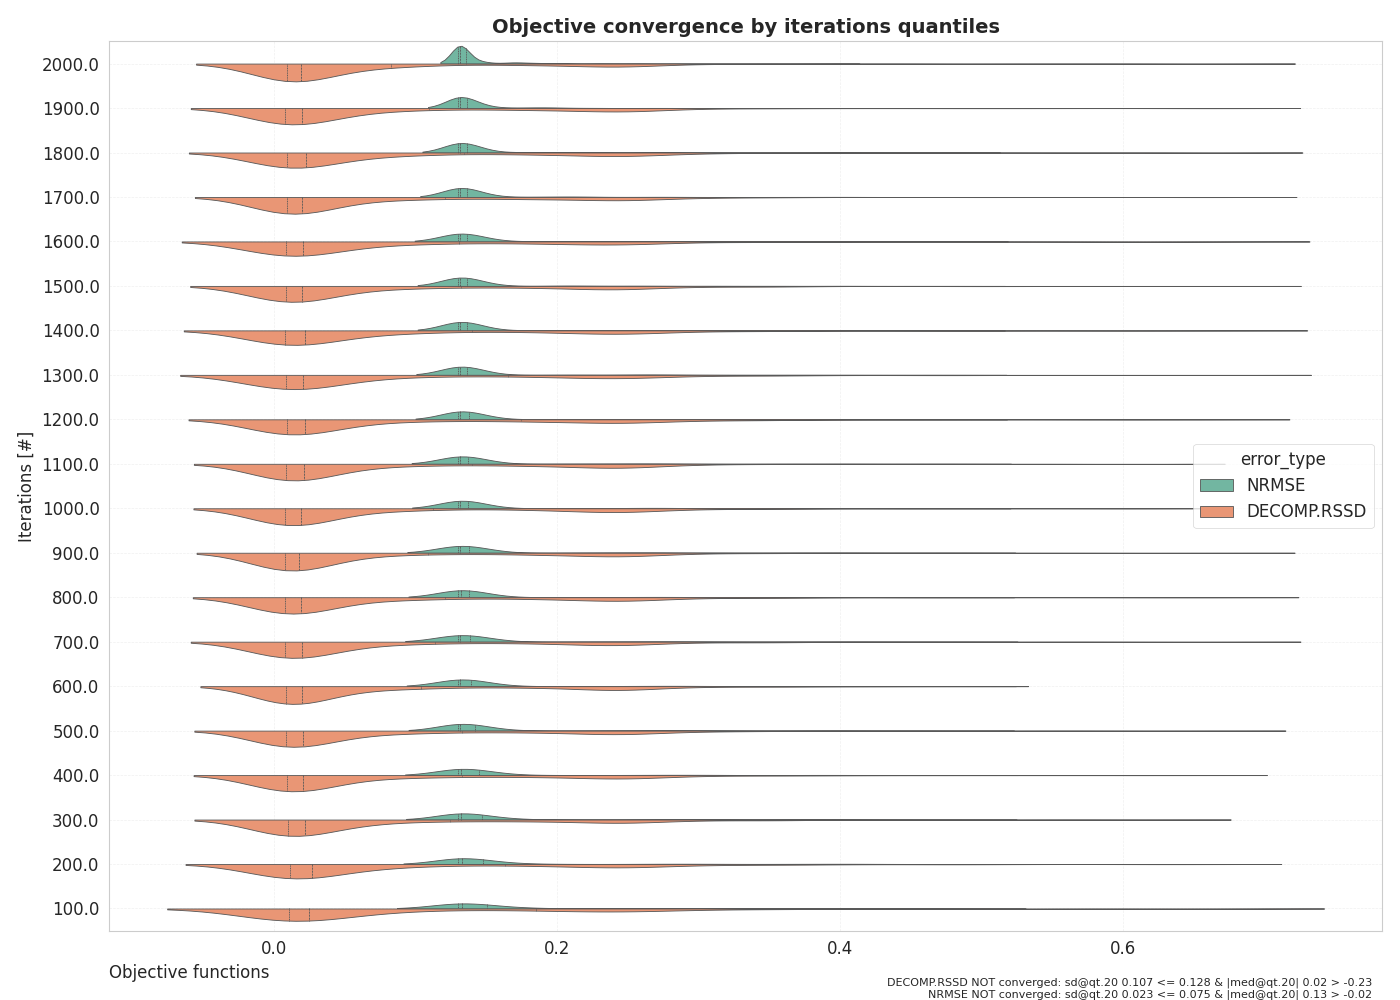

In [12]:
# Display the MOO Distribution Plot
if "moo_distrb_plot" in output_models.convergence:
    moo_distrb_plot = output_models.convergence["moo_distrb_plot"]
    display(Image(data=base64.b64decode(moo_distrb_plot)))

In [13]:
# Create ParetoOptimizer instance
pareto_optimizer = ParetoOptimizer(
    mmm_data, output_models, hyperparameters, featurized_mmm_data, holidays_data
)

# Run optimize function
pareto_result = pareto_optimizer.optimize(pareto_fronts="auto", min_candidates=100)

2025-12-16 20:43:31 [INFO] Starting Pareto optimization
2025-12-16 20:43:31,078 - robyn.modeling.pareto.data_aggregator - INFO - Starting model data aggregation
2025-12-16 20:43:31 [INFO] Computing Pareto fronts
2025-12-16 20:43:31 [INFO] Pareto front computation completed
2025-12-16 20:43:31 [INFO] Preparing Pareto data
2025-12-16 20:43:31 [INFO] Number of Pareto-optimal solutions found: 13458
2025-12-16 20:43:31 [INFO] Selected 4 Pareto-fronts containing 117 candidates
2025-12-16 20:43:31 [INFO] Selected Pareto fronts: 5
2025-12-16 20:43:31 [INFO] Filtering data for selected Pareto fronts...
2025-12-16 20:43:31 [INFO] Pareto data preparation completed
2025-12-16 20:43:31,817 - robyn.modeling.pareto.response_curve - INFO - Calculating response curves for 351 models' media variables...
Processing rows: 100%|██████████| 351/351 [00:05<00:00, 68.97it/s] 
2025-12-16 20:43:39,145 - robyn.modeling.pareto.response_curve - INFO - Successfully processed 351 response curves
2025-12-16 20:43:39,

In [14]:
pareto_result.result_hyp_param['decomp.rssd']

0        0.200670
1        0.782120
2        0.448083
3        0.282603
4        0.779626
           ...   
15995    0.005230
15996    0.022878
15997    0.233242
15998    0.236125
15999    0.022333
Name: decomp.rssd, Length: 16000, dtype: float64

In [16]:
# Filter only DECOMP.RSSD < threshold
#stable_models = pareto_result.result_hyp_param[pareto_result.result_hyp_param['decomp.rssd'] < 0.07]
#
#if len (stable_models) > 0:
#    pareto_result_filtered = stable_models
#else:
#    pareto_result_filtered = pareto_result


cluster_configs = ClusteringConfig(
    dep_var_type=DependentVarType(mmm_data.mmmdata_spec.dep_var_type),
    cluster_by=ClusterBy.HYPERPARAMETERS,
    #cluster_by=ClusterBy.PERFORMANCE,
    max_clusters=7,
    min_clusters=2,
    weights=[1.0, 1.0, 1.0], # nrmse, decomp.rssd, mape.
)

cluster_builder = ClusterBuilder(pareto_result=pareto_result)

cluster_results = cluster_builder.cluster_models(cluster_configs)

2025-12-16 20:45:14,940 - robyn.modeling.clustering.cluster_builder - INFO - Initializing ClusterBuilder
2025-12-16 20:45:14,940 - robyn.modeling.clustering.cluster_builder - INFO - ClusterBuilder initialization complete
2025-12-16 20:45:14,940 - robyn.modeling.clustering.cluster_builder - INFO - Starting model clustering process
2025-12-16 20:45:14,944 - robyn.modeling.clustering.cluster_builder - INFO - Auto-detected media channels: ['google_spend', 'meta_spend', 'tv_spend', 'ga_engaged_sessions', 'ga_page_views', 'meta_reach']
2025-12-16 20:45:14,945 - robyn.modeling.clustering.cluster_builder - INFO - Clustering by: ClusterBy.HYPERPARAMETERS
2025-12-16 20:45:14,946 - robyn.modeling.clustering.cluster_builder - INFO - Starting optimal cluster selection
2025-12-16 20:45:14,946 - robyn.modeling.clustering.cluster_builder - INFO - Ignored features: mape, nrmse_test, decomp.rssd, nrmse_train, nrmse, sol_id, pareto, nrmse_val
2025-12-16 20:45:14,947 - robyn.modeling.clustering.cluster_bu


### Reestablish Pareto Results


In [17]:
from robyn.modeling.pareto.pareto_utils import ParetoUtils

utils = ParetoUtils()
pareto_result = utils.process_pareto_clustered_results(
    pareto_result,
    clustered_result=cluster_results,
    ran_cluster=True,
    ran_calibration=False,
)

In [33]:
top_solutions = cluster_results.top_solutions.sol_id.tolist()
top_solutions

['8_1877_1', '5_1083_1', '7_1811_1', '8_1993_1', '8_1700_1', '8_1773_1']


VALIDAÇÃO ROBYN COM GROUND TRUTH (VERSÃO FINAL CORRIGIDA)

[1/5] Extraindo decomposições...
✅ Decomposições extraídas: (156, 18)
   Período: 2021-01-04 00:00:00 a 2023-12-25 00:00:00

[2/5] Preparando dados...

✅ Dados de validação preparados
   Período: 2021-01-04 00:00:00 a 2023-12-25 00:00:00
   Observações: 156

[3/5] Dividindo treino/teste...
   Treino: 109 obs (69.9%)
   Teste:  47 obs (30.1%)

[4/5] Calculando métricas...

--------------------------------------------------------------------------------
VALIDAÇÃO GLOBAL (REVENUE)
--------------------------------------------------------------------------------

📊 TREINO:
   R² = 1.000
   NRMSE = 0.00%
   MAPE = 0.00%

📊 TESTE:
   R² = 1.000
   NRMSE = 0.00%
   MAPE = 0.00%

⚖️ OVERFITTING SCORE = 0.000
   ✅ Baixo overfitting

--------------------------------------------------------------------------------
VALIDAÇÃO POR COMPONENTE
--------------------------------------------------------------------------------

Base:
   TREINO: MA

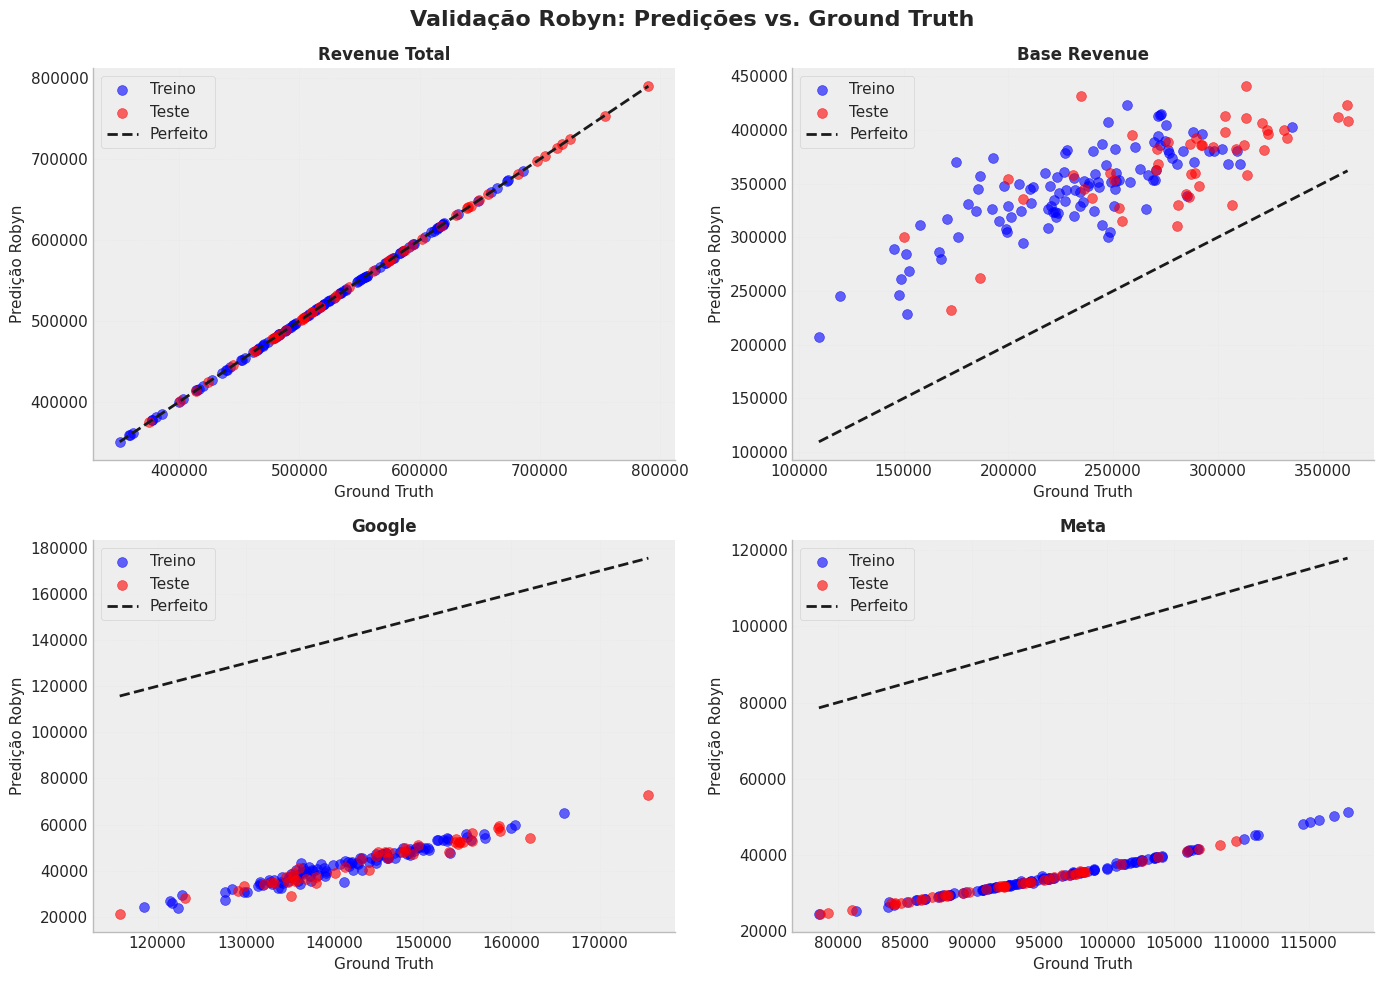


✅ Validação completa! Arquivos salvos em /reports


In [39]:
# ==============================================================================
# VALIDAÇÃO COM GROUND TRUTH - VERSÃO CORRIGIDA
# ==============================================================================

# 1. Importar o módulo corrigido
from validacao_robyn_FINAL import run_validation_corrigida, print_report

# 2. Executar validação
results, validation_df, fig = run_validation_corrigida(
    pareto_result=pareto_result,
    solution_id=top_solutions[0],  # ou '8_1877_1' diretamente
    df_ground_truth=df_media,
    train_size=0.7
)

# 3. Imprimir relatório
print_report(results)

# 4. Salvar resultados
validation_df.to_csv('/home/cairo/mba/tcc-dsa-mcc/reports/validation_data.csv', index=False)
fig.savefig('/home/cairo/mba/tcc-dsa-mcc/reports/validation_plot.png', dpi=300, bbox_inches='tight')

plt.show()

print("\n✅ Validação completa! Arquivos salvos em /reports")

In [40]:
# DIAGNÓSTICO COMPLETO
print("\n" + "="*80)
print("ANÁLISE DETALHADA DAS CONTRIBUIÇÕES")
print("="*80)

for channel in ['google', 'meta', 'tv']:
    true_col = f'true_{channel}_contribution'
    pred_col = f'pred_{channel}_contribution'
    
    print(f"\n{channel.upper()}:")
    print(f"  Ground Truth: Média = {validation_df[true_col].mean():,.0f}")
    print(f"  Robyn Pred:   Média = {validation_df[pred_col].mean():,.0f}")
    print(f"  Diferença:           {validation_df[pred_col].mean() - validation_df[true_col].mean():,.0f}")
    print(f"  Erro relativo:       {(validation_df[pred_col].mean() / validation_df[true_col].mean() - 1) * 100:.1f}%")
    
    # % da receita
    true_pct = validation_df[true_col].sum() / validation_df['revenue'].sum() * 100
    pred_pct = validation_df[pred_col].sum() / validation_df['pred_revenue'].sum() * 100
    print(f"  % Receita (True): {true_pct:.1f}%")
    print(f"  % Receita (Pred): {pred_pct:.1f}%")

# Verificar base revenue
print(f"\nBASE REVENUE:")
print(f"  Ground Truth: Média = {validation_df['true_base_revenue'].mean():,.0f}")
print(f"  Robyn Pred:   Média = {validation_df['pred_base_revenue'].mean():,.0f}")
print(f"  Diferença:           {validation_df['pred_base_revenue'].mean() - validation_df['true_base_revenue'].mean():,.0f}")


ANÁLISE DETALHADA DAS CONTRIBUIÇÕES

GOOGLE:
  Ground Truth: Média = 142,176
  Robyn Pred:   Média = 42,984
  Diferença:           -99,192
  Erro relativo:       -69.8%
  % Receita (True): 26.7%
  % Receita (Pred): 8.0%

META:
  Ground Truth: Média = 95,543
  Robyn Pred:   Média = 34,168
  Diferença:           -61,374
  Erro relativo:       -64.2%
  % Receita (True): 18.0%
  % Receita (Pred): 6.4%

TV:
  Ground Truth: Média = 44,870
  Robyn Pred:   Média = 42,683
  Diferença:           -2,187
  Erro relativo:       -4.9%
  % Receita (True): 8.4%
  % Receita (Pred): 8.0%

BASE REVENUE:
  Ground Truth: Média = 246,809
  Robyn Pred:   Média = 351,493
  Diferença:           104,684


In [ ]:
# Cole este código imediatamente após o erro

#import pandas as pd
#
#print("\n" + "="*80)
#print("DIAGNÓSTICO RÁPIDO")
#print("="*80)
#
## 1. Listar DataFrames disponíveis
#attrs = [a for a in dir(pareto_result) if not a.startswith('_')]
#print(f"\nAtributos do pareto_result:")
#
#for attr_name in attrs[:30]:  # Primeiros 30
#    try:
#        attr = getattr(pareto_result, attr_name)
#        if isinstance(attr, pd.DataFrame) and len(attr) > 0:
#            print(f"\n📊 DataFrame: {attr_name}")
#            print(f"   Shape: {attr.shape}")
#            print(f"   Colunas: {list(attr.columns)[:10]}")
#            
#            # Verificar se tem ID de solução
#            id_cols = [col for col in attr.columns if 'sol' in col.lower()]
#            if id_cols:
#                print(f"   ✅ Coluna de ID encontrada: {id_cols}")
#    except:
#        pass


DIAGNÓSTICO RÁPIDO

Atributos do pareto_result:

📊 DataFrame: df_caov_pct_all
   Shape: (1404, 8)
   Colunas: ['sol_id', 'start_date', 'end_date', 'rn', 'type', 'response', 'percentage', 'carryover_pct']
   ✅ Coluna de ID encontrada: ['sol_id']

📊 DataFrame: media_vec_collect
   Shape: (127296, 11)
   Colunas: ['ds', 'google_spend', 'meta_spend', 'tv_spend', 'ga_engaged_sessions', 'ga_page_views', 'meta_reach', 'type', 'sol_id', 'cluster']
   ✅ Coluna de ID encontrada: ['sol_id', 'top_sol']

📊 DataFrame: result_hyp_param
   Shape: (117, 46)
   Colunas: ['ga_engaged_sessions_alphas', 'ga_engaged_sessions_gammas', 'ga_engaged_sessions_thetas', 'ga_page_views_alphas', 'ga_page_views_gammas', 'ga_page_views_thetas', 'google_spend_alphas', 'google_spend_gammas', 'google_spend_thetas', 'meta_reach_alphas']
   ✅ Coluna de ID encontrada: ['sol_id', 'top_sol']

📊 DataFrame: x_decomp_agg
   Shape: (1404, 49)
   Colunas: ['rn', 'coef', 'xDecompAgg', 'xDecompPerc', 'xDecompMeanNon0', 'xDecompMean

[<Figure size 2000x4000 with 8 Axes>]

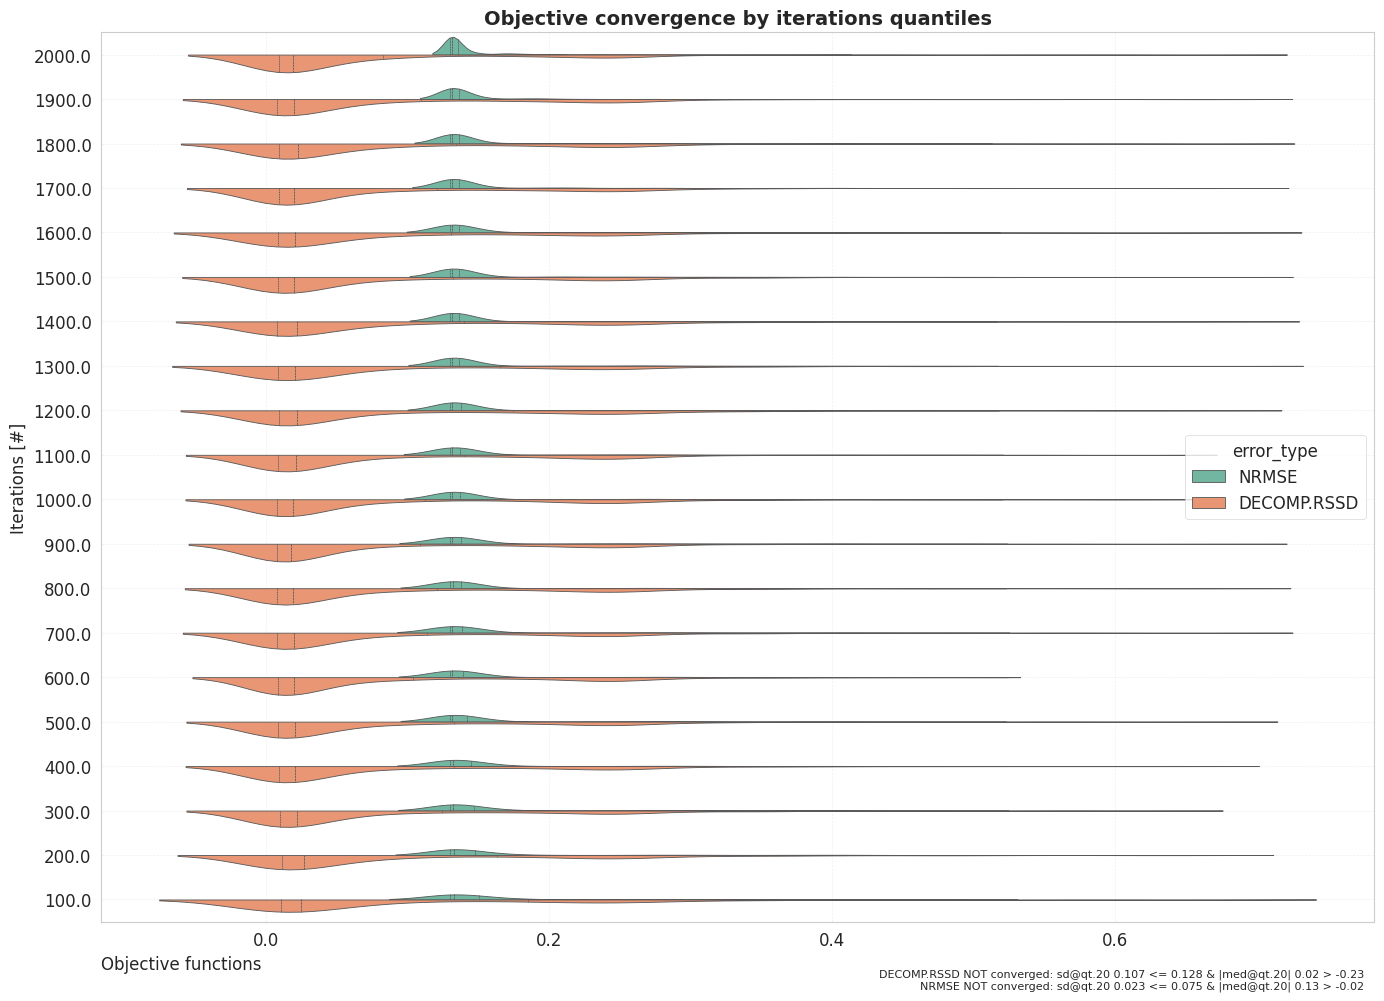

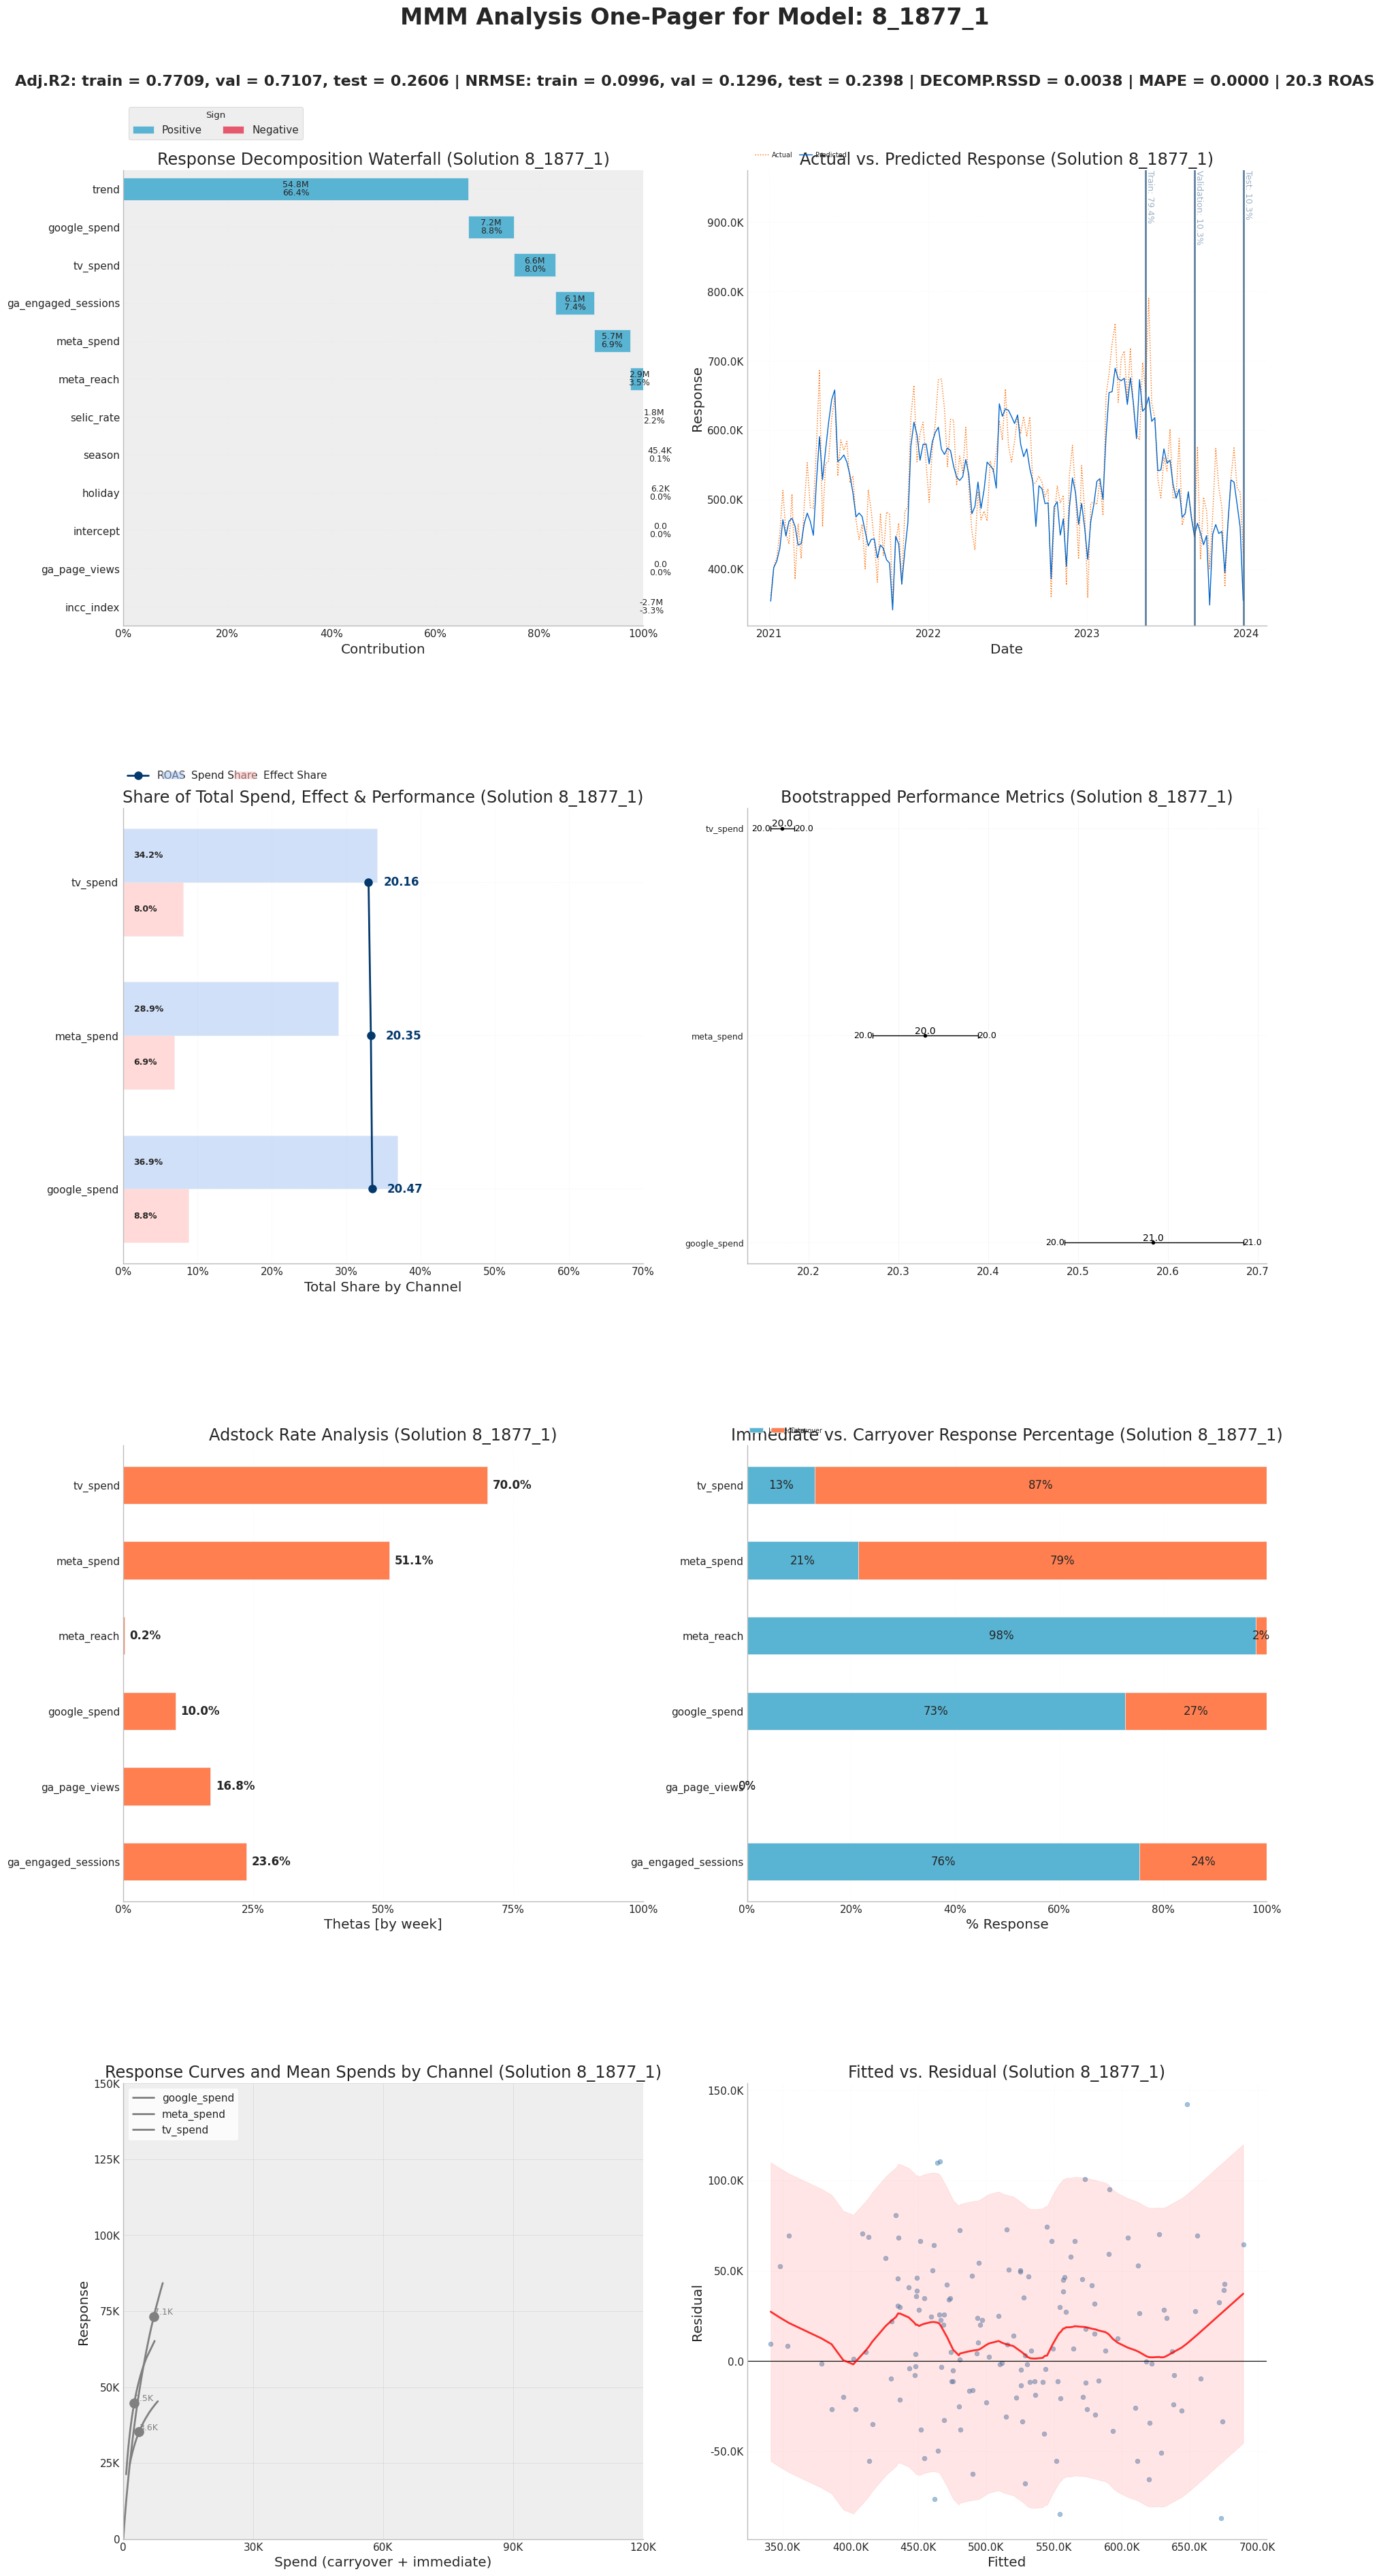

In [ ]:
%matplotlib inline

from robyn.reporting.onepager_reporting import OnePager

OnePager(
    pareto_result, cluster_results, hyperparameters, mmm_data, holidays_data
).generate_one_pager(
    solution_ids=top_solutions[0],
    figsize=(20, 40),
)

### Budget Allocation Optimization

In [ ]:
# Create allocator parameters matching R Example 1
allocator_params = AllocatorParams(
    scenario=SCENARIO_MAX_RESPONSE,
    total_budget=None,  # When None, uses total spend in date_range
    target_value=None,
    date_range=DATE_RANGE_ALL,
    channel_constr_low=[0.7, 0.7, 0.7],  # Adwords / Meta / TV - One value per channel
    channel_constr_up=[1.5, 1.5, 1.5],  # Adwords / Meta / TV - One value per channel
    channel_constr_multiplier=DEFAULT_CONSTRAINT_MULTIPLIER,
    optim_algo=ALGO_SLSQP_AUGLAG,
    maxeval=100000,
    constr_mode=CONSTRAINT_MODE_EQ,
    plots=True,
)

# Initialize budget allocator
max_response_allocator = BudgetAllocator(
    mmm_data=mmm_data,
    featurized_mmm_data=featurized_mmm_data,
    hyperparameters=hyperparameters,
    pareto_result=pareto_result,
    select_model=top_solutions[0],
    params=allocator_params,
)


### Analyze Results

In [ ]:
import numpy as np

results_df = pd.DataFrame(
    {
        "Channel": max_response_allocator.dt_optim_out.channels,
        "Initial Spend": max_response_allocator.dt_optim_out.initSpendUnit,
        "Optimized Spend": max_response_allocator.dt_optim_out.optmSpendUnit,
        "Spend Change %": (
            max_response_allocator.dt_optim_out.optmSpendUnit
            / max_response_allocator.dt_optim_out.initSpendUnit
            - 1
        )
        * 100,
        "Initial Response": max_response_allocator.dt_optim_out.initResponseUnit,
        "Optimized Response": max_response_allocator.dt_optim_out.optmResponseUnit,
        "Response Lift %": (
            max_response_allocator.dt_optim_out.optmResponseUnit
            / max_response_allocator.dt_optim_out.initResponseUnit
            - 1
        )
        * 100,
    }
)

print(results_df.round(2))

                   Channel  Initial Spend  Optimized Spend  Spend Change %  \
google_spend  google_spend        2269.14          3034.56           33.73   
meta_spend      meta_spend        1780.71          1246.50          -30.00   
tv_spend          tv_spend        2103.38          1872.18          -10.99   

              Initial Response  Optimized Response  Response Lift %  
google_spend          44838.05            50135.61            11.81  
meta_spend            35263.90            33269.06            -5.66  
tv_spend              73306.32            71918.17            -1.89  


### Budget Allocation Visualization Results

2025-12-16 20:45:17,589 - robyn.visualization.allocator_visualizer - INFO - Initializing AllocatorPlotter


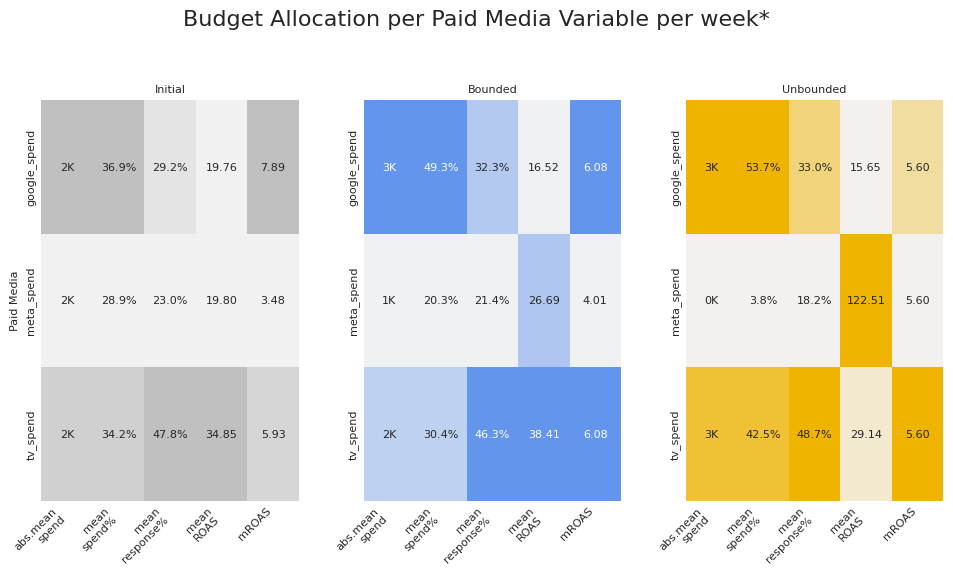

In [ ]:
pio.renderers.default = "notebook"
plotter = AllocatorVisualizer(budget_allocator=max_response_allocator)

plots = plotter.plot_all(display_plots=True, export_location=None)

## Save Results

In [ ]:
#model1_results = results_df.copy()
#model2_results = results_df.copy()
#model4_results = results_df.copy()
#print(model4_results)

In [ ]:
#def to_dict(obj):
#    """
#    Recursively converts a custom object and its nested custom objects
#    into a dictionary.
#    """
#    if hasattr(obj, '__dict__'):
#        return {key: to_dict(value) for key, value in vars(obj).items()}
#    elif isinstance(obj, list):
#        return [to_dict(item) for item in obj]
#    else:
#        return obj

In [ ]:
#model1_hyperparameters = to_dict(hyperparameters)
#model2_hyperparameters = to_dict(hyperparameters)
#model4_hyperparameters = to_dict(hyperparameters)

In [ ]:
#model4_hyperparameters